# Architektur Neuronales Netz

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            #nn.LayerNorm(hidden1_size),
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            #nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            #nn.LayerNorm(hidden2_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            #nn.LayerNorm(hidden3_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 200, 1)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=5, out_features=200, bias=True)
    (2): Tanh()
    (3): Linear(in_features=200, out_features=200, bias=True)
    (4): Tanh()
    (5): Linear(in_features=200, out_features=200, bias=True)
    (6): Tanh()
    (7): Linear(in_features=200, out_features=1, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 32 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs xi
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
xi = torch.tensor(res['xi'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000

# T = torch.tensor(res['T']).float()
# p = torch.tensor(res['p']).float()
# x_0 = torch.tensor(res['x_0']).float()
# xi = torch.tensor(res['xi']).float()

# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = xi.reshape((-1,1))
#print(x_input.size())
# print(xi.size())

# Tensoren zu einem großen Set gruppieren
dataset = TensorDataset(x_input, y_output)

# for x,y in dataset:
#     print(x)
#     print(y)
    
# Split in Trainings und Test Set
train_dataset, test_dataset = random_split(dataset, 
                                           [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
                                           generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 1)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)

#### Funktion zur Bestimmung der Genauigkeit

In [7]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred, y)

            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if pred[i] - y[i] <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f} \n")

    net.train()
    
    return acc, loss, MRE

#### Training

In [8]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients

#         # Record the correct predictions for training data
#         _, predictions = torch.max(pred.data, 1)
#         train_correct += (predictions == y.data).sum()                
#         train_total += predictions.size(0)    

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping
    #train_loss.append(loss.item())
    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)

#     loss = criterion(outputs, Variable(test_classes))
#     test_loss.append(loss.data[0])

Epoch 1/200, Iteration 1/25, Loss: 0.1256
Epoch 1/200, Iteration 2/25, Loss: 1.6641
Epoch 1/200, Iteration 3/25, Loss: 2.4191
Epoch 1/200, Iteration 4/25, Loss: 2.1303
Epoch 1/200, Iteration 5/25, Loss: 0.6458
Epoch 1/200, Iteration 6/25, Loss: 0.5185
Epoch 1/200, Iteration 7/25, Loss: 0.5631
Epoch 1/200, Iteration 8/25, Loss: 0.3528
Epoch 1/200, Iteration 9/25, Loss: 0.4890
Epoch 1/200, Iteration 10/25, Loss: 0.3886
Epoch 1/200, Iteration 11/25, Loss: 0.5903
Epoch 1/200, Iteration 12/25, Loss: 0.5434
Epoch 1/200, Iteration 13/25, Loss: 0.3440
Epoch 1/200, Iteration 14/25, Loss: 0.5287
Epoch 1/200, Iteration 15/25, Loss: 0.5264
Epoch 1/200, Iteration 16/25, Loss: 0.2779
Epoch 1/200, Iteration 17/25, Loss: 0.2595
Epoch 1/200, Iteration 18/25, Loss: 0.3735
Epoch 1/200, Iteration 19/25, Loss: 0.1524
Epoch 1/200, Iteration 20/25, Loss: 0.2615
Epoch 1/200, Iteration 21/25, Loss: 0.3167
Epoch 1/200, Iteration 22/25, Loss: 0.2339
Epoch 1/200, Iteration 23/25, Loss: 0.1605
Epoch 1/200, Iterati

Train Error: 
 Accuracy: 67.12%, Avg loss: 0.077530, MRE: 5.124575 

Test Error: 
 Accuracy: 66.0%, Avg loss: 0.070575, MRE: 15.100382 

Epoch 8/200, Iteration 1/25, Loss: 0.0877
Epoch 8/200, Iteration 2/25, Loss: 0.1040
Epoch 8/200, Iteration 3/25, Loss: 0.1217
Epoch 8/200, Iteration 4/25, Loss: 0.0977
Epoch 8/200, Iteration 5/25, Loss: 0.0711
Epoch 8/200, Iteration 6/25, Loss: 0.0571
Epoch 8/200, Iteration 7/25, Loss: 0.0803
Epoch 8/200, Iteration 8/25, Loss: 0.0538
Epoch 8/200, Iteration 9/25, Loss: 0.0359
Epoch 8/200, Iteration 10/25, Loss: 0.1323
Epoch 8/200, Iteration 11/25, Loss: 0.0973
Epoch 8/200, Iteration 12/25, Loss: 0.1183
Epoch 8/200, Iteration 13/25, Loss: 0.0828
Epoch 8/200, Iteration 14/25, Loss: 0.1014
Epoch 8/200, Iteration 15/25, Loss: 0.0793
Epoch 8/200, Iteration 16/25, Loss: 0.1211
Epoch 8/200, Iteration 17/25, Loss: 0.1539
Epoch 8/200, Iteration 18/25, Loss: 0.0692
Epoch 8/200, Iteration 19/25, Loss: 0.0539
Epoch 8/200, Iteration 20/25, Loss: 0.0797
Epoch 8/200,

Train Error: 
 Accuracy: 7.0%, Avg loss: 0.061190, MRE: 4.301513 

Test Error: 
 Accuracy: 8.0%, Avg loss: 0.060831, MRE: 8.077720 

Epoch 15/200, Iteration 1/25, Loss: 0.0485
Epoch 15/200, Iteration 2/25, Loss: 0.0396
Epoch 15/200, Iteration 3/25, Loss: 0.0380
Epoch 15/200, Iteration 4/25, Loss: 0.0474
Epoch 15/200, Iteration 5/25, Loss: 0.0426
Epoch 15/200, Iteration 6/25, Loss: 0.0261
Epoch 15/200, Iteration 7/25, Loss: 0.0435
Epoch 15/200, Iteration 8/25, Loss: 0.0219
Epoch 15/200, Iteration 9/25, Loss: 0.0211
Epoch 15/200, Iteration 10/25, Loss: 0.0578
Epoch 15/200, Iteration 11/25, Loss: 0.0169
Epoch 15/200, Iteration 12/25, Loss: 0.0589
Epoch 15/200, Iteration 13/25, Loss: 0.0336
Epoch 15/200, Iteration 14/25, Loss: 0.0442
Epoch 15/200, Iteration 15/25, Loss: 0.0337
Epoch 15/200, Iteration 16/25, Loss: 0.0445
Epoch 15/200, Iteration 17/25, Loss: 0.0300
Epoch 15/200, Iteration 18/25, Loss: 0.0257
Epoch 15/200, Iteration 19/25, Loss: 0.0393
Epoch 15/200, Iteration 20/25, Loss: 0.0

Train Error: 
 Accuracy: 61.25%, Avg loss: 0.059104, MRE: 3.825875 

Test Error: 
 Accuracy: 56.0%, Avg loss: 0.057817, MRE: 8.991620 

Epoch 22/200, Iteration 1/25, Loss: 0.0640
Epoch 22/200, Iteration 2/25, Loss: 0.0396
Epoch 22/200, Iteration 3/25, Loss: 0.0396
Epoch 22/200, Iteration 4/25, Loss: 0.0469
Epoch 22/200, Iteration 5/25, Loss: 0.0642
Epoch 22/200, Iteration 6/25, Loss: 0.0412
Epoch 22/200, Iteration 7/25, Loss: 0.0368
Epoch 22/200, Iteration 8/25, Loss: 0.0646
Epoch 22/200, Iteration 9/25, Loss: 0.0413
Epoch 22/200, Iteration 10/25, Loss: 0.0518
Epoch 22/200, Iteration 11/25, Loss: 0.0401
Epoch 22/200, Iteration 12/25, Loss: 0.0743
Epoch 22/200, Iteration 13/25, Loss: 0.0775
Epoch 22/200, Iteration 14/25, Loss: 0.0517
Epoch 22/200, Iteration 15/25, Loss: 0.0788
Epoch 22/200, Iteration 16/25, Loss: 0.0518
Epoch 22/200, Iteration 17/25, Loss: 0.0562
Epoch 22/200, Iteration 18/25, Loss: 0.0633
Epoch 22/200, Iteration 19/25, Loss: 0.0526
Epoch 22/200, Iteration 20/25, Loss: 

Epoch 29/200, Iteration 23/25, Loss: 0.0923
Epoch 29/200, Iteration 24/25, Loss: 0.0979
Epoch 29/200, Iteration 25/25, Loss: 0.1126
Train Error: 
 Accuracy: 56.75%, Avg loss: 0.076131, MRE: 5.003103 

Test Error: 
 Accuracy: 51.5%, Avg loss: 0.067925, MRE: 10.290211 

Epoch 30/200, Iteration 1/25, Loss: 0.0909
Epoch 30/200, Iteration 2/25, Loss: 0.0868
Epoch 30/200, Iteration 3/25, Loss: 0.1115
Epoch 30/200, Iteration 4/25, Loss: 0.0891
Epoch 30/200, Iteration 5/25, Loss: 0.0565
Epoch 30/200, Iteration 6/25, Loss: 0.0503
Epoch 30/200, Iteration 7/25, Loss: 0.1117
Epoch 30/200, Iteration 8/25, Loss: 0.0875
Epoch 30/200, Iteration 9/25, Loss: 0.1197
Epoch 30/200, Iteration 10/25, Loss: 0.1499
Epoch 30/200, Iteration 11/25, Loss: 0.1466
Epoch 30/200, Iteration 12/25, Loss: 0.0915
Epoch 30/200, Iteration 13/25, Loss: 0.0904
Epoch 30/200, Iteration 14/25, Loss: 0.0970
Epoch 30/200, Iteration 15/25, Loss: 0.0491
Epoch 30/200, Iteration 16/25, Loss: 0.1258
Epoch 30/200, Iteration 17/25, Loss:

Epoch 36/200, Iteration 15/25, Loss: 0.0285
Epoch 36/200, Iteration 16/25, Loss: 0.0225
Epoch 36/200, Iteration 17/25, Loss: 0.0309
Epoch 36/200, Iteration 18/25, Loss: 0.0183
Epoch 36/200, Iteration 19/25, Loss: 0.0293
Epoch 36/200, Iteration 20/25, Loss: 0.0301
Epoch 36/200, Iteration 21/25, Loss: 0.0267
Epoch 36/200, Iteration 22/25, Loss: 0.0311
Epoch 36/200, Iteration 23/25, Loss: 0.0353
Epoch 36/200, Iteration 24/25, Loss: 0.0316
Epoch 36/200, Iteration 25/25, Loss: 0.0298
Train Error: 
 Accuracy: 53.75%, Avg loss: 0.016001, MRE: 1.073941 

Test Error: 
 Accuracy: 48.5%, Avg loss: 0.019100, MRE: 1.534807 

Epoch 37/200, Iteration 1/25, Loss: 0.0150
Epoch 37/200, Iteration 2/25, Loss: 0.0155
Epoch 37/200, Iteration 3/25, Loss: 0.0286
Epoch 37/200, Iteration 4/25, Loss: 0.0153
Epoch 37/200, Iteration 5/25, Loss: 0.0228
Epoch 37/200, Iteration 6/25, Loss: 0.0199
Epoch 37/200, Iteration 7/25, Loss: 0.0145
Epoch 37/200, Iteration 8/25, Loss: 0.0366
Epoch 37/200, Iteration 9/25, Loss: 

Epoch 43/200, Iteration 23/25, Loss: 0.0313
Epoch 43/200, Iteration 24/25, Loss: 0.0243
Epoch 43/200, Iteration 25/25, Loss: 0.0102
Train Error: 
 Accuracy: 75.12%, Avg loss: 0.017077, MRE: 1.169996 

Test Error: 
 Accuracy: 70.5%, Avg loss: 0.019231, MRE: 2.410124 

Epoch 44/200, Iteration 1/25, Loss: 0.0254
Epoch 44/200, Iteration 2/25, Loss: 0.0191
Epoch 44/200, Iteration 3/25, Loss: 0.0138
Epoch 44/200, Iteration 4/25, Loss: 0.0182
Epoch 44/200, Iteration 5/25, Loss: 0.0188
Epoch 44/200, Iteration 6/25, Loss: 0.0222
Epoch 44/200, Iteration 7/25, Loss: 0.0166
Epoch 44/200, Iteration 8/25, Loss: 0.0288
Epoch 44/200, Iteration 9/25, Loss: 0.0190
Epoch 44/200, Iteration 10/25, Loss: 0.0135
Epoch 44/200, Iteration 11/25, Loss: 0.0211
Epoch 44/200, Iteration 12/25, Loss: 0.0184
Epoch 44/200, Iteration 13/25, Loss: 0.0172
Epoch 44/200, Iteration 14/25, Loss: 0.0226
Epoch 44/200, Iteration 15/25, Loss: 0.0331
Epoch 44/200, Iteration 16/25, Loss: 0.0222
Epoch 44/200, Iteration 17/25, Loss: 

Train Error: 
 Accuracy: 65.75%, Avg loss: 0.013621, MRE: 0.571524 

Test Error: 
 Accuracy: 56.0%, Avg loss: 0.014893, MRE: 0.601734 

Epoch 51/200, Iteration 1/25, Loss: 0.0191
Epoch 51/200, Iteration 2/25, Loss: 0.0294
Epoch 51/200, Iteration 3/25, Loss: 0.0115
Epoch 51/200, Iteration 4/25, Loss: 0.0221
Epoch 51/200, Iteration 5/25, Loss: 0.0267
Epoch 51/200, Iteration 6/25, Loss: 0.0319
Epoch 51/200, Iteration 7/25, Loss: 0.0261
Epoch 51/200, Iteration 8/25, Loss: 0.0158
Epoch 51/200, Iteration 9/25, Loss: 0.0402
Epoch 51/200, Iteration 10/25, Loss: 0.0180
Epoch 51/200, Iteration 11/25, Loss: 0.0295
Epoch 51/200, Iteration 12/25, Loss: 0.0309
Epoch 51/200, Iteration 13/25, Loss: 0.0453
Epoch 51/200, Iteration 14/25, Loss: 0.0234
Epoch 51/200, Iteration 15/25, Loss: 0.0372
Epoch 51/200, Iteration 16/25, Loss: 0.0416
Epoch 51/200, Iteration 17/25, Loss: 0.0375
Epoch 51/200, Iteration 18/25, Loss: 0.0387
Epoch 51/200, Iteration 19/25, Loss: 0.0313
Epoch 51/200, Iteration 20/25, Loss: 

Epoch 58/200, Iteration 10/25, Loss: 0.0161
Epoch 58/200, Iteration 11/25, Loss: 0.0148
Epoch 58/200, Iteration 12/25, Loss: 0.0322
Epoch 58/200, Iteration 13/25, Loss: 0.0318
Epoch 58/200, Iteration 14/25, Loss: 0.0172
Epoch 58/200, Iteration 15/25, Loss: 0.0095
Epoch 58/200, Iteration 16/25, Loss: 0.0136
Epoch 58/200, Iteration 17/25, Loss: 0.0354
Epoch 58/200, Iteration 18/25, Loss: 0.0213
Epoch 58/200, Iteration 19/25, Loss: 0.0213
Epoch 58/200, Iteration 20/25, Loss: 0.0234
Epoch 58/200, Iteration 21/25, Loss: 0.0131
Epoch 58/200, Iteration 22/25, Loss: 0.0180
Epoch 58/200, Iteration 23/25, Loss: 0.0159
Epoch 58/200, Iteration 24/25, Loss: 0.0185
Epoch 58/200, Iteration 25/25, Loss: 0.0187
Train Error: 
 Accuracy: 64.0%, Avg loss: 0.015768, MRE: 1.064400 

Test Error: 
 Accuracy: 64.5%, Avg loss: 0.017057, MRE: 2.436952 

Epoch 59/200, Iteration 1/25, Loss: 0.0355
Epoch 59/200, Iteration 2/25, Loss: 0.0372
Epoch 59/200, Iteration 3/25, Loss: 0.0298
Epoch 59/200, Iteration 4/25, Lo

Epoch 66/200, Iteration 19/25, Loss: 0.0117
Epoch 66/200, Iteration 20/25, Loss: 0.0149
Epoch 66/200, Iteration 21/25, Loss: 0.0229
Epoch 66/200, Iteration 22/25, Loss: 0.0279
Epoch 66/200, Iteration 23/25, Loss: 0.0350
Epoch 66/200, Iteration 24/25, Loss: 0.0189
Epoch 66/200, Iteration 25/25, Loss: 0.0257
Train Error: 
 Accuracy: 67.25%, Avg loss: 0.022296, MRE: 1.295232 

Test Error: 
 Accuracy: 67.0%, Avg loss: 0.023851, MRE: 1.913656 

Epoch 67/200, Iteration 1/25, Loss: 0.0234
Epoch 67/200, Iteration 2/25, Loss: 0.0254
Epoch 67/200, Iteration 3/25, Loss: 0.0145
Epoch 67/200, Iteration 4/25, Loss: 0.0316
Epoch 67/200, Iteration 5/25, Loss: 0.0257
Epoch 67/200, Iteration 6/25, Loss: 0.0255
Epoch 67/200, Iteration 7/25, Loss: 0.0131
Epoch 67/200, Iteration 8/25, Loss: 0.0222
Epoch 67/200, Iteration 9/25, Loss: 0.0313
Epoch 67/200, Iteration 10/25, Loss: 0.0220
Epoch 67/200, Iteration 11/25, Loss: 0.0285
Epoch 67/200, Iteration 12/25, Loss: 0.0259
Epoch 67/200, Iteration 13/25, Loss: 

Train Error: 
 Accuracy: 78.62%, Avg loss: 0.007029, MRE: 0.413093 

Test Error: 
 Accuracy: 77.0%, Avg loss: 0.007421, MRE: 0.751681 

Epoch 74/200, Iteration 1/25, Loss: 0.0068
Epoch 74/200, Iteration 2/25, Loss: 0.0152
Epoch 74/200, Iteration 3/25, Loss: 0.0126
Epoch 74/200, Iteration 4/25, Loss: 0.0138
Epoch 74/200, Iteration 5/25, Loss: 0.0205
Epoch 74/200, Iteration 6/25, Loss: 0.0115
Epoch 74/200, Iteration 7/25, Loss: 0.0162
Epoch 74/200, Iteration 8/25, Loss: 0.0184
Epoch 74/200, Iteration 9/25, Loss: 0.0103
Epoch 74/200, Iteration 10/25, Loss: 0.0160
Epoch 74/200, Iteration 11/25, Loss: 0.0476
Epoch 74/200, Iteration 12/25, Loss: 0.0105
Epoch 74/200, Iteration 13/25, Loss: 0.0079
Epoch 74/200, Iteration 14/25, Loss: 0.0111
Epoch 74/200, Iteration 15/25, Loss: 0.0304
Epoch 74/200, Iteration 16/25, Loss: 0.0283
Epoch 74/200, Iteration 17/25, Loss: 0.0085
Epoch 74/200, Iteration 18/25, Loss: 0.0107
Epoch 74/200, Iteration 19/25, Loss: 0.0302
Epoch 74/200, Iteration 20/25, Loss: 

Epoch 80/200, Iteration 23/25, Loss: 0.0092
Epoch 80/200, Iteration 24/25, Loss: 0.0301
Epoch 80/200, Iteration 25/25, Loss: 0.0136
Train Error: 
 Accuracy: 82.5%, Avg loss: 0.007545, MRE: 0.563215 

Test Error: 
 Accuracy: 79.0%, Avg loss: 0.008152, MRE: 1.032021 

Epoch 81/200, Iteration 1/25, Loss: 0.0240
Epoch 81/200, Iteration 2/25, Loss: 0.0150
Epoch 81/200, Iteration 3/25, Loss: 0.0078
Epoch 81/200, Iteration 4/25, Loss: 0.0214
Epoch 81/200, Iteration 5/25, Loss: 0.0111
Epoch 81/200, Iteration 6/25, Loss: 0.0107
Epoch 81/200, Iteration 7/25, Loss: 0.0125
Epoch 81/200, Iteration 8/25, Loss: 0.0080
Epoch 81/200, Iteration 9/25, Loss: 0.0124
Epoch 81/200, Iteration 10/25, Loss: 0.0128
Epoch 81/200, Iteration 11/25, Loss: 0.0091
Epoch 81/200, Iteration 12/25, Loss: 0.0173
Epoch 81/200, Iteration 13/25, Loss: 0.0279
Epoch 81/200, Iteration 14/25, Loss: 0.0280
Epoch 81/200, Iteration 15/25, Loss: 0.0089
Epoch 81/200, Iteration 16/25, Loss: 0.0089
Epoch 81/200, Iteration 17/25, Loss: 0

Epoch 88/200, Iteration 24/25, Loss: 0.0149
Epoch 88/200, Iteration 25/25, Loss: 0.0185
Train Error: 
 Accuracy: 87.38%, Avg loss: 0.005864, MRE: 0.290918 

Test Error: 
 Accuracy: 83.5%, Avg loss: 0.006697, MRE: 0.603762 

Epoch 89/200, Iteration 1/25, Loss: 0.0072
Epoch 89/200, Iteration 2/25, Loss: 0.0183
Epoch 89/200, Iteration 3/25, Loss: 0.0174
Epoch 89/200, Iteration 4/25, Loss: 0.0122
Epoch 89/200, Iteration 5/25, Loss: 0.0098
Epoch 89/200, Iteration 6/25, Loss: 0.0257
Epoch 89/200, Iteration 7/25, Loss: 0.0228
Epoch 89/200, Iteration 8/25, Loss: 0.0123
Epoch 89/200, Iteration 9/25, Loss: 0.0127
Epoch 89/200, Iteration 10/25, Loss: 0.0124
Epoch 89/200, Iteration 11/25, Loss: 0.0122
Epoch 89/200, Iteration 12/25, Loss: 0.0151
Epoch 89/200, Iteration 13/25, Loss: 0.0240
Epoch 89/200, Iteration 14/25, Loss: 0.0085
Epoch 89/200, Iteration 15/25, Loss: 0.0152
Epoch 89/200, Iteration 16/25, Loss: 0.0129
Epoch 89/200, Iteration 17/25, Loss: 0.0077
Epoch 89/200, Iteration 18/25, Loss: 

Train Error: 
 Accuracy: 97.25%, Avg loss: 0.005310, MRE: 0.303112 

Test Error: 
 Accuracy: 94.5%, Avg loss: 0.005797, MRE: 0.845791 

Epoch 96/200, Iteration 1/25, Loss: 0.0080
Epoch 96/200, Iteration 2/25, Loss: 0.0108
Epoch 96/200, Iteration 3/25, Loss: 0.0101
Epoch 96/200, Iteration 4/25, Loss: 0.0067
Epoch 96/200, Iteration 5/25, Loss: 0.0158
Epoch 96/200, Iteration 6/25, Loss: 0.0103
Epoch 96/200, Iteration 7/25, Loss: 0.0353
Epoch 96/200, Iteration 8/25, Loss: 0.0082
Epoch 96/200, Iteration 9/25, Loss: 0.0074
Epoch 96/200, Iteration 10/25, Loss: 0.0146
Epoch 96/200, Iteration 11/25, Loss: 0.0124
Epoch 96/200, Iteration 12/25, Loss: 0.0206
Epoch 96/200, Iteration 13/25, Loss: 0.0147
Epoch 96/200, Iteration 14/25, Loss: 0.0233
Epoch 96/200, Iteration 15/25, Loss: 0.0419
Epoch 96/200, Iteration 16/25, Loss: 0.0229
Epoch 96/200, Iteration 17/25, Loss: 0.0152
Epoch 96/200, Iteration 18/25, Loss: 0.0097
Epoch 96/200, Iteration 19/25, Loss: 0.0244
Epoch 96/200, Iteration 20/25, Loss: 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.005838, MRE: 1.027735 

Epoch 103/200, Iteration 1/25, Loss: 0.0153
Epoch 103/200, Iteration 2/25, Loss: 0.0173
Epoch 103/200, Iteration 3/25, Loss: 0.0177
Epoch 103/200, Iteration 4/25, Loss: 0.0070
Epoch 103/200, Iteration 5/25, Loss: 0.0177
Epoch 103/200, Iteration 6/25, Loss: 0.0159
Epoch 103/200, Iteration 7/25, Loss: 0.0057
Epoch 103/200, Iteration 8/25, Loss: 0.0095
Epoch 103/200, Iteration 9/25, Loss: 0.0071
Epoch 103/200, Iteration 10/25, Loss: 0.0234
Epoch 103/200, Iteration 11/25, Loss: 0.0079
Epoch 103/200, Iteration 12/25, Loss: 0.0218
Epoch 103/200, Iteration 13/25, Loss: 0.0121
Epoch 103/200, Iteration 14/25, Loss: 0.0084
Epoch 103/200, Iteration 15/25, Loss: 0.0112
Epoch 103/200, Iteration 16/25, Loss: 0.0231
Epoch 103/200, Iteration 17/25, Loss: 0.0103
Epoch 103/200, Iteration 18/25, Loss: 0.0224
Epoch 103/200, Iteration 19/25, Loss: 0.0216
Epoch 103/200, Iteration 20/25, Loss: 0.0309
Epoch 103/200, Iteration 21/25, Loss: 0.02

Train Error: 
 Accuracy: 90.0%, Avg loss: 0.005261, MRE: 0.299080 

Test Error: 
 Accuracy: 83.0%, Avg loss: 0.005920, MRE: 0.766327 

Epoch 110/200, Iteration 1/25, Loss: 0.0058
Epoch 110/200, Iteration 2/25, Loss: 0.0111
Epoch 110/200, Iteration 3/25, Loss: 0.0051
Epoch 110/200, Iteration 4/25, Loss: 0.0063
Epoch 110/200, Iteration 5/25, Loss: 0.0113
Epoch 110/200, Iteration 6/25, Loss: 0.0136
Epoch 110/200, Iteration 7/25, Loss: 0.0289
Epoch 110/200, Iteration 8/25, Loss: 0.0133
Epoch 110/200, Iteration 9/25, Loss: 0.0084
Epoch 110/200, Iteration 10/25, Loss: 0.0270
Epoch 110/200, Iteration 11/25, Loss: 0.0115
Epoch 110/200, Iteration 12/25, Loss: 0.0167
Epoch 110/200, Iteration 13/25, Loss: 0.0211
Epoch 110/200, Iteration 14/25, Loss: 0.0138
Epoch 110/200, Iteration 15/25, Loss: 0.0075
Epoch 110/200, Iteration 16/25, Loss: 0.0201
Epoch 110/200, Iteration 17/25, Loss: 0.0098
Epoch 110/200, Iteration 18/25, Loss: 0.0238
Epoch 110/200, Iteration 19/25, Loss: 0.0086
Epoch 110/200, Iter

Epoch 117/200, Iteration 12/25, Loss: 0.0157
Epoch 117/200, Iteration 13/25, Loss: 0.0091
Epoch 117/200, Iteration 14/25, Loss: 0.0105
Epoch 117/200, Iteration 15/25, Loss: 0.0086
Epoch 117/200, Iteration 16/25, Loss: 0.0220
Epoch 117/200, Iteration 17/25, Loss: 0.0093
Epoch 117/200, Iteration 18/25, Loss: 0.0389
Epoch 117/200, Iteration 19/25, Loss: 0.0131
Epoch 117/200, Iteration 20/25, Loss: 0.0120
Epoch 117/200, Iteration 21/25, Loss: 0.0240
Epoch 117/200, Iteration 22/25, Loss: 0.0081
Epoch 117/200, Iteration 23/25, Loss: 0.0144
Epoch 117/200, Iteration 24/25, Loss: 0.0264
Epoch 117/200, Iteration 25/25, Loss: 0.0210
Train Error: 
 Accuracy: 98.25%, Avg loss: 0.005436, MRE: 0.272562 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.006523, MRE: 0.944109 

Epoch 118/200, Iteration 1/25, Loss: 0.0135
Epoch 118/200, Iteration 2/25, Loss: 0.0189
Epoch 118/200, Iteration 3/25, Loss: 0.0349
Epoch 118/200, Iteration 4/25, Loss: 0.0099
Epoch 118/200, Iteration 5/25, Loss: 0.0141
Epoch 118/200,

Epoch 124/200, Iteration 14/25, Loss: 0.0108
Epoch 124/200, Iteration 15/25, Loss: 0.0067
Epoch 124/200, Iteration 16/25, Loss: 0.0167
Epoch 124/200, Iteration 17/25, Loss: 0.0144
Epoch 124/200, Iteration 18/25, Loss: 0.0208
Epoch 124/200, Iteration 19/25, Loss: 0.0098
Epoch 124/200, Iteration 20/25, Loss: 0.0089
Epoch 124/200, Iteration 21/25, Loss: 0.0094
Epoch 124/200, Iteration 22/25, Loss: 0.0124
Epoch 124/200, Iteration 23/25, Loss: 0.0187
Epoch 124/200, Iteration 24/25, Loss: 0.0196
Epoch 124/200, Iteration 25/25, Loss: 0.0297
Train Error: 
 Accuracy: 94.88%, Avg loss: 0.004571, MRE: 0.275194 

Test Error: 
 Accuracy: 90.0%, Avg loss: 0.005037, MRE: 0.952328 

Epoch 125/200, Iteration 1/25, Loss: 0.0121
Epoch 125/200, Iteration 2/25, Loss: 0.0065
Epoch 125/200, Iteration 3/25, Loss: 0.0075
Epoch 125/200, Iteration 4/25, Loss: 0.0123
Epoch 125/200, Iteration 5/25, Loss: 0.0099
Epoch 125/200, Iteration 6/25, Loss: 0.0239
Epoch 125/200, Iteration 7/25, Loss: 0.0073
Epoch 125/200, I

Train Error: 
 Accuracy: 97.12%, Avg loss: 0.004822, MRE: 0.272209 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.005518, MRE: 0.987860 

Epoch 132/200, Iteration 1/25, Loss: 0.0217
Epoch 132/200, Iteration 2/25, Loss: 0.0149
Epoch 132/200, Iteration 3/25, Loss: 0.0060
Epoch 132/200, Iteration 4/25, Loss: 0.0098
Epoch 132/200, Iteration 5/25, Loss: 0.0101
Epoch 132/200, Iteration 6/25, Loss: 0.0198
Epoch 132/200, Iteration 7/25, Loss: 0.0418
Epoch 132/200, Iteration 8/25, Loss: 0.0115
Epoch 132/200, Iteration 9/25, Loss: 0.0102
Epoch 132/200, Iteration 10/25, Loss: 0.0245
Epoch 132/200, Iteration 11/25, Loss: 0.0090
Epoch 132/200, Iteration 12/25, Loss: 0.0070
Epoch 132/200, Iteration 13/25, Loss: 0.0215
Epoch 132/200, Iteration 14/25, Loss: 0.0075
Epoch 132/200, Iteration 15/25, Loss: 0.0103
Epoch 132/200, Iteration 16/25, Loss: 0.0148
Epoch 132/200, Iteration 17/25, Loss: 0.0175
Epoch 132/200, Iteration 18/25, Loss: 0.0308
Epoch 132/200, Iteration 19/25, Loss: 0.0160
Epoch 132/200, Ite

Epoch 139/200, Iteration 1/25, Loss: 0.0121
Epoch 139/200, Iteration 2/25, Loss: 0.0178
Epoch 139/200, Iteration 3/25, Loss: 0.0158
Epoch 139/200, Iteration 4/25, Loss: 0.0065
Epoch 139/200, Iteration 5/25, Loss: 0.0216
Epoch 139/200, Iteration 6/25, Loss: 0.0327
Epoch 139/200, Iteration 7/25, Loss: 0.0148
Epoch 139/200, Iteration 8/25, Loss: 0.0062
Epoch 139/200, Iteration 9/25, Loss: 0.0133
Epoch 139/200, Iteration 10/25, Loss: 0.0109
Epoch 139/200, Iteration 11/25, Loss: 0.0099
Epoch 139/200, Iteration 12/25, Loss: 0.0075
Epoch 139/200, Iteration 13/25, Loss: 0.0160
Epoch 139/200, Iteration 14/25, Loss: 0.0194
Epoch 139/200, Iteration 15/25, Loss: 0.0100
Epoch 139/200, Iteration 16/25, Loss: 0.0081
Epoch 139/200, Iteration 17/25, Loss: 0.0125
Epoch 139/200, Iteration 18/25, Loss: 0.0419
Epoch 139/200, Iteration 19/25, Loss: 0.0124
Epoch 139/200, Iteration 20/25, Loss: 0.0111
Epoch 139/200, Iteration 21/25, Loss: 0.0229
Epoch 139/200, Iteration 22/25, Loss: 0.0166
Epoch 139/200, Iter

Epoch 146/200, Iteration 20/25, Loss: 0.0185
Epoch 146/200, Iteration 21/25, Loss: 0.0230
Epoch 146/200, Iteration 22/25, Loss: 0.0138
Epoch 146/200, Iteration 23/25, Loss: 0.0077
Epoch 146/200, Iteration 24/25, Loss: 0.0085
Epoch 146/200, Iteration 25/25, Loss: 0.0276
Train Error: 
 Accuracy: 98.5%, Avg loss: 0.006100, MRE: 0.360009 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.006528, MRE: 0.992524 

Epoch 147/200, Iteration 1/25, Loss: 0.0183
Epoch 147/200, Iteration 2/25, Loss: 0.0169
Epoch 147/200, Iteration 3/25, Loss: 0.0075
Epoch 147/200, Iteration 4/25, Loss: 0.0186
Epoch 147/200, Iteration 5/25, Loss: 0.0130
Epoch 147/200, Iteration 6/25, Loss: 0.0193
Epoch 147/200, Iteration 7/25, Loss: 0.0047
Epoch 147/200, Iteration 8/25, Loss: 0.0298
Epoch 147/200, Iteration 9/25, Loss: 0.0190
Epoch 147/200, Iteration 10/25, Loss: 0.0096
Epoch 147/200, Iteration 11/25, Loss: 0.0136
Epoch 147/200, Iteration 12/25, Loss: 0.0192
Epoch 147/200, Iteration 13/25, Loss: 0.0199
Epoch 147/200, Iter

Epoch 154/200, Iteration 7/25, Loss: 0.0228
Epoch 154/200, Iteration 8/25, Loss: 0.0340
Epoch 154/200, Iteration 9/25, Loss: 0.0082
Epoch 154/200, Iteration 10/25, Loss: 0.0251
Epoch 154/200, Iteration 11/25, Loss: 0.0317
Epoch 154/200, Iteration 12/25, Loss: 0.0122
Epoch 154/200, Iteration 13/25, Loss: 0.0058
Epoch 154/200, Iteration 14/25, Loss: 0.0082
Epoch 154/200, Iteration 15/25, Loss: 0.0096
Epoch 154/200, Iteration 16/25, Loss: 0.0100
Epoch 154/200, Iteration 17/25, Loss: 0.0178
Epoch 154/200, Iteration 18/25, Loss: 0.0265
Epoch 154/200, Iteration 19/25, Loss: 0.0200
Epoch 154/200, Iteration 20/25, Loss: 0.0218
Epoch 154/200, Iteration 21/25, Loss: 0.0168
Epoch 154/200, Iteration 22/25, Loss: 0.0114
Epoch 154/200, Iteration 23/25, Loss: 0.0135
Epoch 154/200, Iteration 24/25, Loss: 0.0087
Epoch 154/200, Iteration 25/25, Loss: 0.0230
Train Error: 
 Accuracy: 98.25%, Avg loss: 0.004899, MRE: 0.204653 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.005829, MRE: 0.649721 

Epoch 155/20

Epoch 161/200, Iteration 19/25, Loss: 0.0062
Epoch 161/200, Iteration 20/25, Loss: 0.0097
Epoch 161/200, Iteration 21/25, Loss: 0.0145
Epoch 161/200, Iteration 22/25, Loss: 0.0240
Epoch 161/200, Iteration 23/25, Loss: 0.0128
Epoch 161/200, Iteration 24/25, Loss: 0.0077
Epoch 161/200, Iteration 25/25, Loss: 0.0096
Train Error: 
 Accuracy: 96.25%, Avg loss: 0.004457, MRE: 0.226459 

Test Error: 
 Accuracy: 91.0%, Avg loss: 0.005217, MRE: 0.857380 

Epoch 162/200, Iteration 1/25, Loss: 0.0121
Epoch 162/200, Iteration 2/25, Loss: 0.0103
Epoch 162/200, Iteration 3/25, Loss: 0.0144
Epoch 162/200, Iteration 4/25, Loss: 0.0063
Epoch 162/200, Iteration 5/25, Loss: 0.0190
Epoch 162/200, Iteration 6/25, Loss: 0.0117
Epoch 162/200, Iteration 7/25, Loss: 0.0065
Epoch 162/200, Iteration 8/25, Loss: 0.0108
Epoch 162/200, Iteration 9/25, Loss: 0.0100
Epoch 162/200, Iteration 10/25, Loss: 0.0086
Epoch 162/200, Iteration 11/25, Loss: 0.0278
Epoch 162/200, Iteration 12/25, Loss: 0.0186
Epoch 162/200, Ite

Epoch 169/200, Iteration 9/25, Loss: 0.0145
Epoch 169/200, Iteration 10/25, Loss: 0.0120
Epoch 169/200, Iteration 11/25, Loss: 0.0212
Epoch 169/200, Iteration 12/25, Loss: 0.0057
Epoch 169/200, Iteration 13/25, Loss: 0.0151
Epoch 169/200, Iteration 14/25, Loss: 0.0069
Epoch 169/200, Iteration 15/25, Loss: 0.0060
Epoch 169/200, Iteration 16/25, Loss: 0.0295
Epoch 169/200, Iteration 17/25, Loss: 0.0284
Epoch 169/200, Iteration 18/25, Loss: 0.0077
Epoch 169/200, Iteration 19/25, Loss: 0.0127
Epoch 169/200, Iteration 20/25, Loss: 0.0078
Epoch 169/200, Iteration 21/25, Loss: 0.0183
Epoch 169/200, Iteration 22/25, Loss: 0.0217
Epoch 169/200, Iteration 23/25, Loss: 0.0126
Epoch 169/200, Iteration 24/25, Loss: 0.0198
Epoch 169/200, Iteration 25/25, Loss: 0.0191
Train Error: 
 Accuracy: 96.38%, Avg loss: 0.004637, MRE: 0.264439 

Test Error: 
 Accuracy: 91.5%, Avg loss: 0.005808, MRE: 0.670838 

Epoch 170/200, Iteration 1/25, Loss: 0.0166
Epoch 170/200, Iteration 2/25, Loss: 0.0139
Epoch 170/20

Epoch 176/200, Iteration 11/25, Loss: 0.0099
Epoch 176/200, Iteration 12/25, Loss: 0.0044
Epoch 176/200, Iteration 13/25, Loss: 0.0068
Epoch 176/200, Iteration 14/25, Loss: 0.0079
Epoch 176/200, Iteration 15/25, Loss: 0.0093
Epoch 176/200, Iteration 16/25, Loss: 0.0089
Epoch 176/200, Iteration 17/25, Loss: 0.0101
Epoch 176/200, Iteration 18/25, Loss: 0.0133
Epoch 176/200, Iteration 19/25, Loss: 0.0087
Epoch 176/200, Iteration 20/25, Loss: 0.0144
Epoch 176/200, Iteration 21/25, Loss: 0.0113
Epoch 176/200, Iteration 22/25, Loss: 0.0093
Epoch 176/200, Iteration 23/25, Loss: 0.0119
Epoch 176/200, Iteration 24/25, Loss: 0.0071
Epoch 176/200, Iteration 25/25, Loss: 0.0207
Train Error: 
 Accuracy: 96.88%, Avg loss: 0.004412, MRE: 0.275350 

Test Error: 
 Accuracy: 92.0%, Avg loss: 0.005343, MRE: 0.784134 

Epoch 177/200, Iteration 1/25, Loss: 0.0103
Epoch 177/200, Iteration 2/25, Loss: 0.0167
Epoch 177/200, Iteration 3/25, Loss: 0.0069
Epoch 177/200, Iteration 4/25, Loss: 0.0229
Epoch 177/200

Epoch 183/200, Iteration 13/25, Loss: 0.0118
Epoch 183/200, Iteration 14/25, Loss: 0.0109
Epoch 183/200, Iteration 15/25, Loss: 0.0156
Epoch 183/200, Iteration 16/25, Loss: 0.0223
Epoch 183/200, Iteration 17/25, Loss: 0.0047
Epoch 183/200, Iteration 18/25, Loss: 0.0059
Epoch 183/200, Iteration 19/25, Loss: 0.0228
Epoch 183/200, Iteration 20/25, Loss: 0.0208
Epoch 183/200, Iteration 21/25, Loss: 0.0260
Epoch 183/200, Iteration 22/25, Loss: 0.0122
Epoch 183/200, Iteration 23/25, Loss: 0.0078
Epoch 183/200, Iteration 24/25, Loss: 0.0104
Epoch 183/200, Iteration 25/25, Loss: 0.0173
Train Error: 
 Accuracy: 96.75%, Avg loss: 0.004606, MRE: 0.219525 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.005248, MRE: 0.821849 

Epoch 184/200, Iteration 1/25, Loss: 0.0140
Epoch 184/200, Iteration 2/25, Loss: 0.0110
Epoch 184/200, Iteration 3/25, Loss: 0.0132
Epoch 184/200, Iteration 4/25, Loss: 0.0163
Epoch 184/200, Iteration 5/25, Loss: 0.0120
Epoch 184/200, Iteration 6/25, Loss: 0.0245
Epoch 184/200, 

Epoch 191/200, Iteration 8/25, Loss: 0.0070
Epoch 191/200, Iteration 9/25, Loss: 0.0099
Epoch 191/200, Iteration 10/25, Loss: 0.0061
Epoch 191/200, Iteration 11/25, Loss: 0.0096
Epoch 191/200, Iteration 12/25, Loss: 0.0098
Epoch 191/200, Iteration 13/25, Loss: 0.0070
Epoch 191/200, Iteration 14/25, Loss: 0.0117
Epoch 191/200, Iteration 15/25, Loss: 0.0109
Epoch 191/200, Iteration 16/25, Loss: 0.0126
Epoch 191/200, Iteration 17/25, Loss: 0.0116
Epoch 191/200, Iteration 18/25, Loss: 0.0127
Epoch 191/200, Iteration 19/25, Loss: 0.0099
Epoch 191/200, Iteration 20/25, Loss: 0.0271
Epoch 191/200, Iteration 21/25, Loss: 0.0095
Epoch 191/200, Iteration 22/25, Loss: 0.0111
Epoch 191/200, Iteration 23/25, Loss: 0.0082
Epoch 191/200, Iteration 24/25, Loss: 0.0096
Epoch 191/200, Iteration 25/25, Loss: 0.0134
Train Error: 
 Accuracy: 95.0%, Avg loss: 0.004755, MRE: 0.286040 

Test Error: 
 Accuracy: 88.5%, Avg loss: 0.005755, MRE: 0.748552 

Epoch 192/200, Iteration 1/25, Loss: 0.0158
Epoch 192/200

Train Error: 
 Accuracy: 98.38%, Avg loss: 0.005093, MRE: 0.245845 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.005826, MRE: 0.712218 

Epoch 198/200, Iteration 1/25, Loss: 0.0130
Epoch 198/200, Iteration 2/25, Loss: 0.0124
Epoch 198/200, Iteration 3/25, Loss: 0.0180
Epoch 198/200, Iteration 4/25, Loss: 0.0255
Epoch 198/200, Iteration 5/25, Loss: 0.0116
Epoch 198/200, Iteration 6/25, Loss: 0.0128
Epoch 198/200, Iteration 7/25, Loss: 0.0155
Epoch 198/200, Iteration 8/25, Loss: 0.0125
Epoch 198/200, Iteration 9/25, Loss: 0.0123
Epoch 198/200, Iteration 10/25, Loss: 0.0078
Epoch 198/200, Iteration 11/25, Loss: 0.0074
Epoch 198/200, Iteration 12/25, Loss: 0.0083
Epoch 198/200, Iteration 13/25, Loss: 0.0105
Epoch 198/200, Iteration 14/25, Loss: 0.0133
Epoch 198/200, Iteration 15/25, Loss: 0.0162
Epoch 198/200, Iteration 16/25, Loss: 0.0162
Epoch 198/200, Iteration 17/25, Loss: 0.0093
Epoch 198/200, Iteration 18/25, Loss: 0.0266
Epoch 198/200, Iteration 19/25, Loss: 0.0147
Epoch 198/200, Ite

#### Plots loss vs Epoch

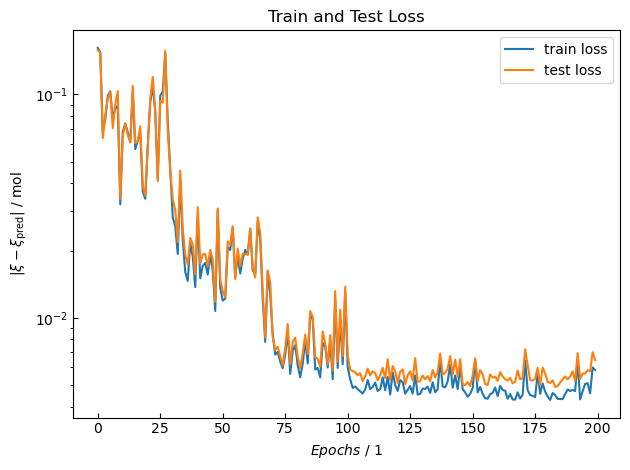

In [9]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

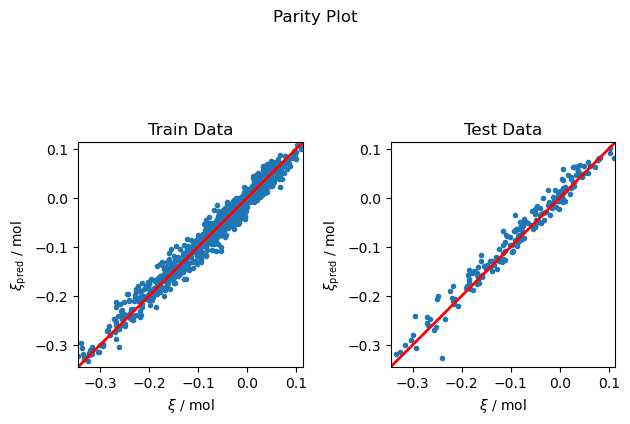

In [10]:
xi_real = []
xi_pred = []
for (X,y) in train_dataloader:
    xi_real = np.append(xi_real, y.numpy())
    xi_pred = np.append(xi_pred, net(X).detach().numpy())

xi_real_test = []
xi_pred_test = []
for (X,y) in test_dataloader:
    xi_real_test = np.append(xi_real_test, y.numpy())
    xi_pred_test = np.append(xi_pred_test, net(X).detach().numpy())

# find the boundaries of X and Y values
bounds = (min(xi_real.min(), xi_pred.min()) - int(0.1 * xi_pred.min()), max(xi_real.max(), xi_pred.max())+ int(0.1 * xi_pred.max()))

fig,ax = plt.subplots(1,2)

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(xi_real, xi_pred, '.')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[0].set_title('Train Data')

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(xi_real_test, xi_pred_test, '.')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[1].set_title('Test Data')


#plt.legend()
fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

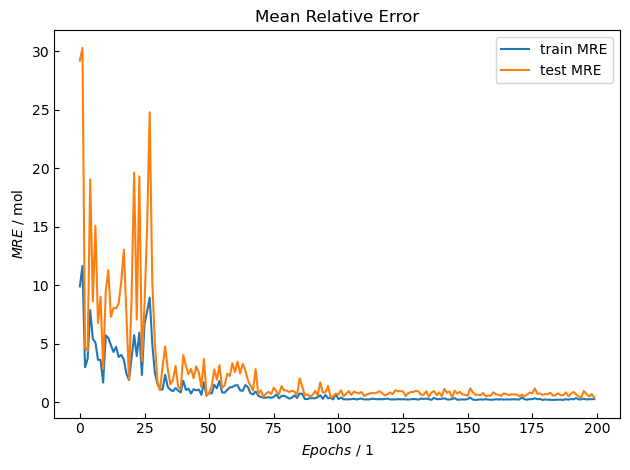

In [11]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_MRE, label='train MRE')
ax.plot(test_MRE, label='test MRE')
plt.title("Mean Relative Error")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

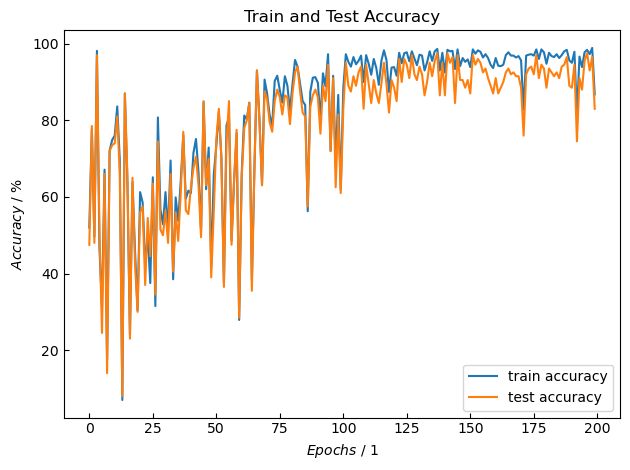

In [12]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [13]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y.reshape((-1,1)))
    print(net(X))
    break

tensor([[7.6026e+02, 2.4762e+02, 1.9959e-01, 4.3750e-01, 3.6291e-01],
        [7.0393e+02, 1.4382e+02, 6.7222e-01, 8.9779e-02, 2.3800e-01],
        [7.5848e+02, 1.5138e+02, 3.2251e-01, 3.8973e-01, 2.8776e-01],
        [6.9609e+02, 1.6460e+02, 3.8021e-01, 5.6382e-01, 5.5977e-02],
        [6.8322e+02, 1.7510e+02, 9.4181e-02, 1.6315e-01, 7.4267e-01],
        [8.0640e+02, 1.2691e+02, 2.3638e-01, 2.7437e-02, 7.3618e-01],
        [6.8280e+02, 1.8802e+02, 9.7175e-02, 1.9358e-01, 7.0925e-01],
        [7.5918e+02, 1.8176e+02, 3.3022e-01, 1.2455e-01, 5.4523e-01],
        [8.1185e+02, 1.1529e+02, 4.6300e-01, 1.4389e-01, 3.9311e-01],
        [7.5854e+02, 1.2120e+02, 1.5827e-01, 2.5804e-01, 5.8369e-01],
        [7.5555e+02, 2.3286e+02, 5.3796e-02, 5.1268e-01, 4.3353e-01],
        [8.4053e+02, 1.0272e+02, 3.5345e-01, 1.9915e-02, 6.2663e-01],
        [7.9661e+02, 2.4494e+02, 4.3193e-01, 4.3688e-01, 1.3119e-01],
        [6.9203e+02, 1.1971e+02, 1.8870e-01, 7.2026e-01, 9.1036e-02],
        [6.7574e+02,

#### Einblick in Netzwerk

In [14]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([0.7458, 0.8389, 0.8984, 0.7948, 0.8519], requires_grad=True),
 Parameter containing:
 tensor([-0.0689, -0.2660,  0.0168, -0.0274,  0.0137], requires_grad=True),
 Parameter containing:
 tensor([[ 2.3938e-01, -1.8067e-01,  4.1292e-01, -2.0364e-01, -1.8421e-01],
         [-2.8663e-01, -2.1985e-01, -2.7037e-01, -1.9061e-01, -1.4830e-01],
         [-1.2756e-01,  2.2180e-02,  2.5207e-02,  1.4196e-01, -1.1855e-02],
         [-1.5824e-01,  9.5892e-02,  1.5196e-01,  1.6633e-01, -1.7990e-01],
         [-2.9537e-01, -2.6901e-01, -1.4610e-02,  3.5587e-02, -3.5792e-01],
         [-2.4405e-01, -4.8686e-01, -3.9310e-01, -3.8893e-02,  5.3895e-02],
         [-8.8034e-02, -1.5732e-01, -8.0183e-02,  5.6721e-02, -1.2757e-02],
         [-8.5597e-02, -2.1174e-02, -4.6792e-02, -1.1540e-01,  1.3048e-01],
         [-2.3046e-02, -5.4602e-02, -9.1305e-02,  1.8396e-01, -1.5482e-01],
         [ 1.4450e-01, -1.5495e-02,  1.9352e-01,  2.1399e-01,  3.3255e-01],
         [ 4.2327e-01,  

In [15]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.4104, 0.5882, 0.8801, 0.0219, 0.1133],
        [0.3508, 0.2417, 0.5582, 0.1962, 0.8653]])
tensor([[ 0.0165],
        [-0.1030]], grad_fn=<AddmmBackward0>)


In [16]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [17]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    break

tensor([[7.4359e+02, 1.2095e+02, 9.8929e-02, 3.9438e-01, 5.0669e-01],
        [7.9241e+02, 1.3365e+02, 2.6424e-01, 4.2288e-01, 3.1288e-01],
        [7.7372e+02, 2.0126e+02, 1.2444e-02, 8.0541e-01, 1.8215e-01],
        [7.9285e+02, 1.8020e+02, 4.9785e-01, 4.1357e-01, 8.8582e-02],
        [7.9036e+02, 1.7611e+02, 6.7031e-01, 2.1799e-01, 1.1170e-01],
        [7.6077e+02, 1.9698e+02, 7.3367e-01, 2.3838e-01, 2.7947e-02],
        [6.9770e+02, 2.4807e+02, 1.6104e-01, 6.3038e-01, 2.0857e-01],
        [6.7348e+02, 2.4946e+02, 3.2166e-01, 1.4695e-01, 5.3139e-01],
        [7.9531e+02, 1.5096e+02, 8.7242e-01, 4.8267e-02, 7.9316e-02],
        [8.4800e+02, 1.6312e+02, 3.4769e-01, 4.0314e-01, 2.4917e-01],
        [7.6440e+02, 1.6123e+02, 6.3620e-02, 6.8532e-01, 2.5106e-01],
        [8.3285e+02, 2.3753e+02, 1.3592e-01, 7.6493e-01, 9.9156e-02],
        [8.3073e+02, 1.0875e+02, 4.2303e-01, 8.0101e-02, 4.9687e-01],
        [7.8662e+02, 1.4209e+02, 1.3679e-01, 8.1887e-01, 4.4340e-02],
        [6.6798e+02,